# Análisis de resultados de Pron vs. Prompt

En este cuaderno analizamos los datos del experimento Pron vs. Prompt. Principalmente, haremos un análisis descriptivo y de correlaciones. Dejamos el modelo de efectos mixtos para R.

In [44]:
!pip install matplotlib

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import copy
import numpy as np
import matplotlib

# Configurar la fuente de toda la figura en Times New Roman
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Times New Roman'

Unas variables auxiliares que nos permitirán seleccionar subconjuntos de los datos.

In [46]:
columns_study = ['1_atractivo_titulo',
       '1_atractivo_estilo', '1_atractivo_tema', '2_originalidad_titulo',
       '2_originalidad_estilo', '2_originalidad_tema', '3_relevancia',
       '4_creatividad_titulo', '4_creatividad_sinopsis',
       '5_autoria_titulo', '5_autoria_sinopsis',
       '6_antologia', '6_opinion_lectores',
       '6_opinion_criticos', '6_voz_propia',]
columns_numeric_title = ['1_atractivo_titulo', 
       '2_originalidad_titulo', 
       '4_creatividad_titulo',]
columns_numeric_synopsis = ['1_atractivo_estilo', '1_atractivo_tema',
        '2_originalidad_estilo', '2_originalidad_tema',
       '4_creatividad_sinopsis', ]
       # '6_antologia', '6_opinion_lectores', '6_opinion_criticos', '6_voz_propia']
columns_numeric_synopsis_without6 = ['1_atractivo_estilo', '1_atractivo_tema',
        '2_originalidad_estilo', '2_originalidad_tema',
       '4_creatividad_sinopsis',]

#### Preparación de los DataFrames

Vamos a generar unas ids para las distintas operaciones sobre los datos.
- ``id_item``: nos permite identificar de manera unívoca la sinopsis que ha escrito un agente, pero no distingue entre evaluadores.
- ``id_user``: nos permite identificar cada sinopsis votada por cada crítico. No distingue entre escritores, esto nos permite hacer merge con los datos de Patricio, por un lado, y de GPT por otro.

In [47]:
df = pd.read_csv('data/resultados_en_bruto.csv')
df['id_title_sinopsis_writer'] = df['title_id'] + '_' + df['sinopsis_writer']
df['id_title_title_writer'] = df['title_id'] + '_' + df['title_writer']
df['id_title_user'] = df['title_id'] + '_' + df['username'] 
df.columns

Index(['Unnamed: 0', 'timestamp', 'username', '1_atractivo_titulo',
       '1_atractivo_estilo', '1_atractivo_tema', '2_originalidad_titulo',
       '2_originalidad_estilo', '2_originalidad_tema', '3_relevancia',
       '4_creatividad_titulo', '4_creatividad_sinopsis',
       '4_creatividad_comentario', '5_autoria_titulo', '5_autoria_sinopsis',
       '5_autoria_comentario', '6_antologia', '6_opinion_lectores',
       '6_opinion_criticos', '6_voz_propia', '6_comentario', 'title',
       'title_id', 'sinopsis_writer', 'title_writer', 'experiment',
       'id_title_sinopsis_writer', 'id_title_title_writer', 'id_for_es_en',
       'id_title_user'],
      dtype='object')

Ahora creamos los DataFrame para estudiar, separados por escritor de cada sinopsis, que es el objetivo principal de nuestro experimento. Esa diferencia.

In [48]:
def select_df_by(df, selector = 'sinopsis'):
    df = copy.copy(df)
    df[columns_numeric_synopsis] += 1
    mode = f'{selector}_writer'

    if selector == 'sinopsis':
        df = df.drop(columns=columns_numeric_title).reset_index(drop=True)
        df_gpt_en = df[df[mode] == 'gpt4_en'].reset_index(drop=True)
        df_gpt_es = df[df[mode] == 'gpt4_es'].reset_index(drop=True)
        join_id = 'id_title_user'

    else:
        df = df.drop(columns=columns_numeric_synopsis).reset_index(drop=True)
        df_gpt_en = df[df[mode] == 'machine'].reset_index(drop=True)
        df_gpt_es = df_gpt_en
        join_id = 'id_title_user'

    df_es = df[df.experiment=='SPANISH']
    df_en = df[df.experiment=='ENGLISH']

    df_patricio = df[df[mode] == 'patricio'].reset_index(drop=True)
    df_patricio_es = df_es[df_es[mode] == 'patricio']
    df_patricio_en = df_en[df_en[mode] == 'patricio']
    df_patricio_gpt_es = df_patricio_es.merge(df_gpt_es, on=join_id, suffixes=('_patricio', '_gpt4')).transpose().sort_index().transpose()
    df_patricio_gpt_en = df_patricio_en.merge(df_gpt_en, on=join_id, suffixes=('_patricio', '_gpt4')).transpose().sort_index().transpose()
    df_patricio_es_patricio_en = df_patricio_en.merge(df_patricio_es, on='title_id', suffixes=('_patricio_en', '_patricio_es')).transpose().sort_index().transpose()
    
    df_gpt_es_gpt_en = df_gpt_es.merge(df_gpt_en, on=join_id, suffixes=('_patricio', '_gpt4')).transpose().sort_index().transpose()

    df_gpt_en.to_csv('data/df_gpt_en.csv')
    df_gpt_es.to_csv('data/df_gpt_es.csv')
    df_patricio.to_csv('data/df_patricio.csv')
    df_patricio_gpt_es.to_csv('data/df_patricio_gpt_es.csv')
    df_patricio_gpt_en.to_csv('data/df_patricio_gpt_en.csv')
    df_patricio_es_patricio_en.to_csv('data/df_patricio_es_patricio_en.csv')
    df_gpt_es_gpt_en.to_csv('data/df_gpt_es_gpt_en.csv')

    return {'df_gpt_en':df_gpt_en,
            'df_gpt_es':df_gpt_es,
            'df_patricio':df_patricio,
            'df_patricio_gpt_es':df_patricio_gpt_es,
            'df_patricio_gpt_en':df_patricio_gpt_en,
            'df_patricio_es_patricio_en':df_patricio_es_patricio_en,
            'df_gpt_es_gpt_en':df_gpt_es_gpt_en}

In [49]:
dfs_title = select_df_by(df, 'title')

In [50]:
dfs_sinopsis = select_df_by(df, 'sinopsis')


## Dibujar la detección 

Queremos dibujar respecto al tiempo la capacidad de los revisores de detectar si una sinopsis está escrita por un humano o una máquina.

In [51]:
def save_plot(ax, user : str):
    ax.set_xlabel('Number of the sinopsis in the time')
    ax.set_ylabel('Authorship Attribution Success')
    yticks = np.arange(0, 1 + 1, 1)
    ax.set_yticks(yticks)
    plt.tight_layout()
    plt.savefig(f'figures/{user}.pdf', backend='pgf', bbox_inches='tight', pad_inches=0.1)
    plt.show()

In [52]:
map_autoria = {'Una inteligencia artificial.':'AI', 'Un escritor novel.':'Writer', 'Un escritor consagrado.':'Writer'}
map_writer_en = {'gpt4_en':'AI', 'patricio':'Writer'}
map_writer_es = {'gpt4_es':'AI', 'patricio':'Writer'}

In [53]:
evaluators_en = ['itzihern@ucm.es', 'maguirao@ucm.es', 'albertosesmero91@gmail.com']
evaluators_es = ['amarinur@gmail.com', 'israelprados@gmail.com', 'enrique@escueladeescritores.com']

In [54]:
df['username'].unique()

array(['itzihern@ucm.es', 'maguirao@ucm.es', 'albertosesmero91@gmail.com',
       'amarinur@gmail.com', 'israelprados@gmail.com',
       'enrique@escueladeescritores.com'], dtype=object)

In [55]:
def get_plots_and_means_acc(author):

    df_user_aggr = pd.DataFrame()
    for user in df['username'].unique():
        print (user)
        # filtramos usuarios por el nombre
        df_user = copy.copy(df.loc[df.username==user])
        # mapeamos la autoría
        df_user['Authorship Attribution'] = df_user['5_autoria_sinopsis'].apply(lambda x : map_autoria[x])
        # en la columna del escritor de la sinopsis tb
        if user in evaluators_en:
            df_user['Synopsis Origin'] = df_user['sinopsis_writer'].apply(lambda x : map_writer_en[x])
        else:
            df_user['Synopsis Origin'] = df_user['sinopsis_writer'].apply(lambda x : map_writer_es[x])
        # creamos una columna nueva con las coincidencias en las votaciones
        df_user['Authorship Attribution Successes'] = df_user['Synopsis Origin']==df_user['Authorship Attribution']
        # pasamos los trues a numéricos
        df_user['Authorship Attribution Successes'] = df_user['Authorship Attribution Successes'].apply(lambda x: 1 if x else 0)
        # ordenamos por el tiempo
        df_user = df_user.sort_values(by='timestamp').reset_index()
        # filtramos las sinopsis escritas solo por IA
        df_user = df_user[df_user['Synopsis Origin'] == author]
        df_user_aggr[user.split('@')[0]] = copy.copy(df_user['Authorship Attribution Successes'].tolist())
        if 'mean' in df_user_aggr.columns:
            df_user_aggr = df_user_aggr.drop(columns=['mean'])
        df_user_aggr['mean'] = df_user_aggr.mean(axis=1)
        save_plot(df_user['Authorship Attribution Successes'].plot.line(), user)
    return df_user_aggr 

itzihern@ucm.es


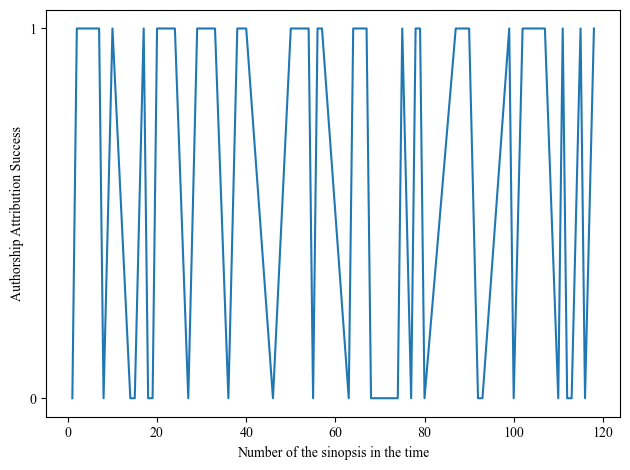

maguirao@ucm.es


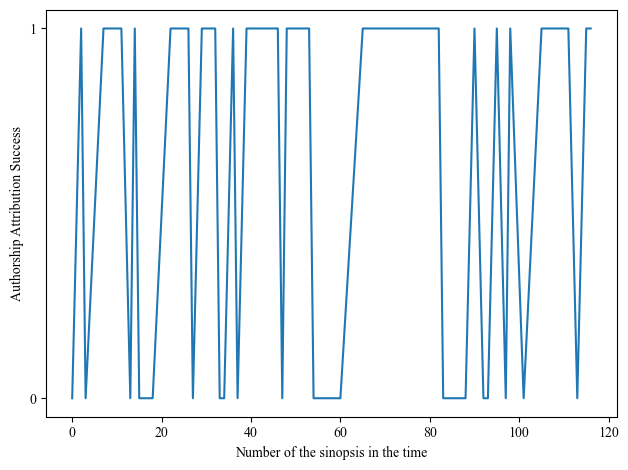

albertosesmero91@gmail.com


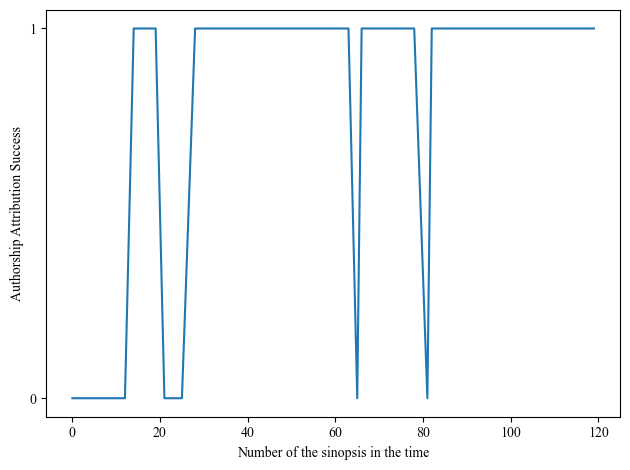

amarinur@gmail.com


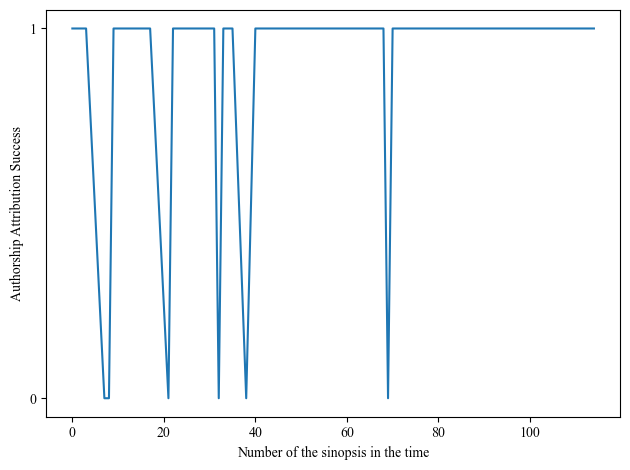

israelprados@gmail.com


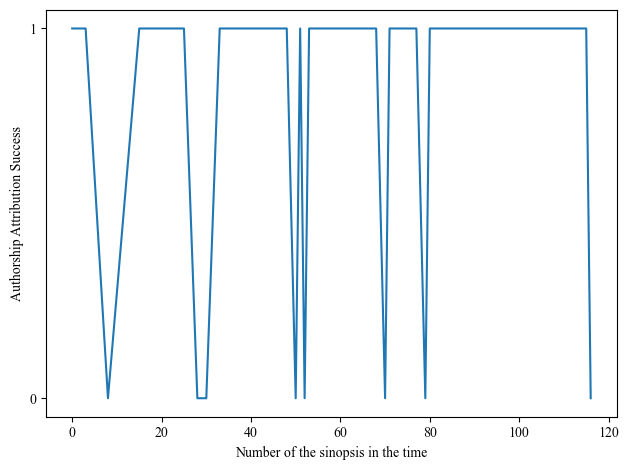

enrique@escueladeescritores.com


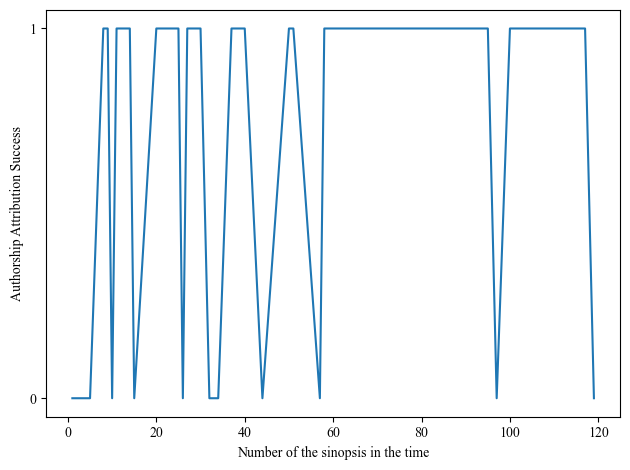

itzihern@ucm.es


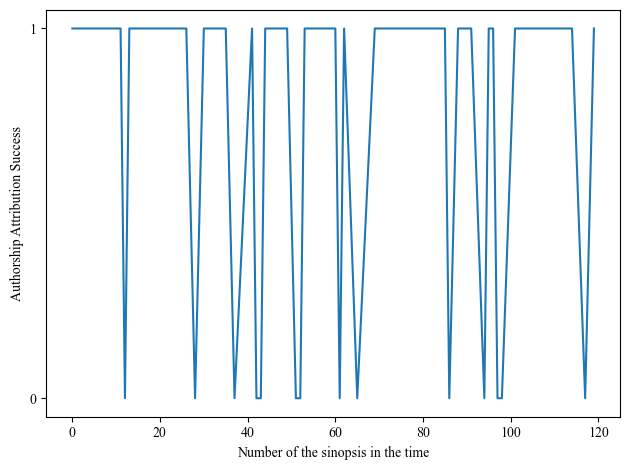

maguirao@ucm.es


In [56]:
df_user_aggr_IA = get_plots_and_means_acc('AI')
df_user_aggr_Writer = get_plots_and_means_acc('Writer')

In [ ]:
df_two_plots = pd.DataFrame()

In [ ]:
df_two_plots['AI'] = df_user_aggr_IA['mean']
df_two_plots['Writer'] = df_user_aggr_Writer['mean']

In [ ]:
df_two_plots.to_csv('accu.csv')

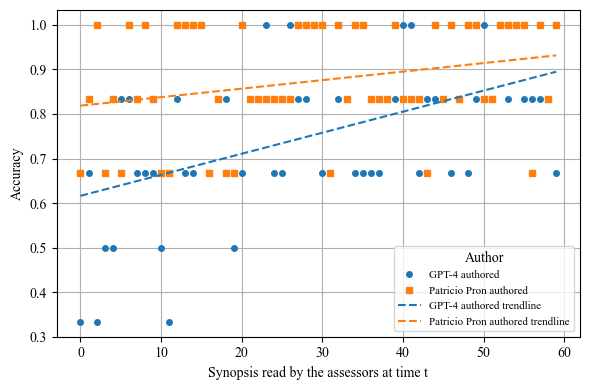

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

accuracy_data = df_two_plots

# Extraer los datos
# Extraer los datos
index = accuracy_data.index
ai_accuracy = accuracy_data['AI']
writer_accuracy = accuracy_data['Writer']

# Crear las líneas de tendencia
z_ai = np.polyfit(index, ai_accuracy, 1)
p_ai = np.poly1d(z_ai)

z_writer = np.polyfit(index, writer_accuracy, 1)
p_writer = np.poly1d(z_writer)

# Colores elegantes para las líneas y los puntos
ai_color = '#1f77b4'  # Azul para AI
writer_color = '#ff7f0e'  # Naranja para Writer

# Plotear los datos como puntos
plt.figure(figsize=(6, 4))
plt.plot(index, ai_accuracy, 'o', label='GPT-4 authored', color=ai_color, markersize=4)
plt.plot(index, writer_accuracy, 's', label='Patricio Pron authored', color=writer_color, markersize=4)

# Plotear las líneas de tendencia
plt.plot(index, p_ai(index), '--', label='GPT-4 authored trendline', color=ai_color, linewidth=1.5)
plt.plot(index, p_writer(index), '--', label='Patricio Pron authored trendline', color=writer_color, linewidth=1.5)

# Agregar etiquetas y título
plt.xlabel('Synopsis read by the assessors at time t', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
#plt.title('Accuracy Comparison with Trendlines', fontsize=12)
plt.legend(fontsize=8, title='Author')
plt.grid(True)

# Ajustar los márgenes para ocupar menos espacio
plt.tight_layout()

# Guardar la figura como PDF
plt.savefig('accuracy_comparison.pdf', format='pdf', bbox_inches='tight')

# Mostrar el gráfico
plt.show()
